In [1]:
#!python -m pip install networkx
#!python -m pip install matplotlib==2.2.3
#!python -m pip install ipywidgets
#!python -m pip install graphviz
#!python -m pip install pandas
#!python -m pip install pudb
# !python -m pip install nbconvert

In [2]:
# coding=utf-8
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib
plt.rcParams['figure.figsize'] = [12, 12]
import random
import copy
#from ipywidgets import GridspecLayout, Button, Layout
import math
import sys
from graphviz import Digraph
import pylab

import time
import networkx as nx
from networkx import *
import os
import pickle


Bad key text.latex.unicode in file /home/fran/.local/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 112 ('text.latex.unicode : False # use "ucs" and "inputenc" LaTeX packages for handling')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.4.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.frameon in file /home/fran/.local/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 423 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.4.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key pgf.debug in file /home/fran/.local/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 444 ('pgf.debug           : False')
You probably need to get an updated matplotlibrc file from
https://github.com/mat

Using matplotlib backend: TkAgg


In [3]:
class Slot():

    def __init__(self, word, is_core, page_destination):
        '''
        word : str que l'on souhaite traiter et placer sur la grille
        is Core : Booléen un indiquant si le mot traité fait parti du vocabulaire core ou non
        page_destination : page liée à ce slot
        '''

        self.__word = copy.copy(word)
        self.__is_core = copy.copy(is_core)
        self.__page_destination = copy.copy(page_destination)

    # Accesseur
    def get_word(self):

        return self.__word

    # Accesseur
    def get_is_core(self):

        return self.__is_core

    def get_page_destination(self):

        return self.__page_destination

    def set_word(self, word):

        self.__word = word

    def set_page_destination(self, page):

        self.__page_destination = page

    def __str__(self):

        dest = self.__page_destination
        if dest:
            dest = self.__page_destination.get_name()
        # return '('+str(self.__word) + ';' + str(self.__is_core) + ';' + str(dest) + ')'
        return f'{self.__word}({dest})'



In [4]:
class Page():

    #Constructor
    def __init__(self, name, row_size, col_size):

        self.__name = name
        self.__row_size = row_size
        self.__col_size = col_size
        self.__full = False
        self.__slots = []
        self.__fill()
        self.__last_R = 0
        self.__last_C = 0

    #Initialise chacun des slots à None
    def __fill(self):

      self.__slots = []
      for i in range(0, self.__row_size) :
        self.__slots.append([None])
        for j in range(0, self.__col_size) :
          self.__slots[i].append(None)

    # Ajoute le Slot slot en position num_row, num_col et renvoie l'ancienne valeur
    def set_slot(self, slot, num_row, num_col):

      if (num_row >= self.__row_size) or (num_col >= self.__col_size):
        print(f'row={num_row}, col={num_col}')
        print(f'row_size={self.__row_size}, col_size={self.__col_size}')
                
        raise Exception('Error: slot row or col out of bounds') 

      old_value = self.__slots[num_row][num_col]
      self.__slots[num_row][num_col] = slot

      return old_value

    def set_name(self, name):
      self.__name = name

      return name

    # Accessors
    def get_name(self):

      return self.__name

    def get_row_size(self):

      return self.__row_size

    def get_col_size(self):

      return self.__col_size

    def get_slot(self, num_row, num_col):

      return self.__slots[num_row][num_col]

    def get_slot_by_name(self, name):

      for row in range(0, self.__row_size):
        for col in range (0, self.__col_size):
          slot = self.__slots[row][col]
          if slot:          
            if slot.get_word() == name:
              return slot
          
      print(f'*** slot {name} not found in page {self.__name} ***')
      return None
    
    def get_pictograms(self):

      current_page_name = self.get_name()
      attributes = {}
      for row in range(0, self.__row_size):
        for col in range (0, self.__col_size):
          slot = self.__slots[row][col]
          if slot:
            word = slot.get_word()
            dest = slot.get_page_destination()
            if dest:
              dest_page_name = dest.get_name()
            else:
              dest_page_name = None

            id = f'{word}@{current_page_name}'
            if id in attributes:
              id = f'{id}**'

            attributes[id] = [word, row, col, current_page_name, dest_page_name]  

      return attributes
      
    # def get_slot_by_destination(self, dest):
      
    #   for row in range(0, self.__row_size):
    #     for col in range (0, self.__col_size):
    #       slot = self.__slots[row][col]
    #       if slot:          
    #         if slot.get_page_destination == dest:
    #           return slot
          
    #   print(f'*** destination {dest} not found in any slot ofpage {self.__name} ***')
    #   return None

    def get_slot_list(self):

      return self.__slots

    #Return true if the slot at position (num_row, num_col) is free, false otherwise
    def is_free(self, num_row, num_col):

      return self.__slots[num_row][num_col] == None

    #Return true if table is full, false otherwise
    def is_full(self):

      if (self.__full):
        return True
      for row in range(0, self.__row_size):
        for col in range (0, self.__col_size):
          if self.__slots[row][col] == None:
            return False
      self.__full = True
      return True

    def add_word(self, word, core=False, dest=None) :

      if(self.__last_C == self.__col_size) : 
        self.__last_C = 0
        self.__last_R += 1
      if(self.__last_R == self.__row_size) :
        self.__full = True
        print("Failed to add word <", word, ">. The table is full.")
        return None

      if(self.__slots[self.__last_R][self.__last_C] == None) :

        s = Slot(word, core, dest)
        self.__slots[self.__last_R][self.__last_C] = s
        self.__last_R
        self.__last_C += 1
        return word
      
      self.__last_R
      self.__last_C += 1
      return self.add_word(word, dest=dest)

    # Méthode d'affichage (à revoir ? Efficacité chaînes de caractères)
    def __str__(self):

      s = "Page: " + self.__name + "\n("
      for i in range(0, self.__row_size) : 
        for j in range(0, self.__col_size) :
          s+=str(self.__slots[i][j])
          s+=", "
        s+='\n'
      return s+')'

    # fonction auxiliaire pour l'affichage
    def create_expanded_button(self, description, button_style):

      return Button(description=description, button_style=button_style,
                  layout=Layout(height='auto', width='auto'))
       
    # Affichage alternative (couteaux, debug)
    def show(self):

      grid = GridspecLayout(self.__row_size, self.__col_size, width='50%')

      for i in range(self.__row_size):
        for j in range(self.__col_size):
          # grid[i, j] = self.create_expanded_button('Button {} - {}'.format(i, j), 'success')
          if self.__slots[i][j]:
            content = str(self.__slots[i][j])
          else:
            content = ''
          grid[i, j] = self.create_expanded_button(content, 'success')            


      return grid



## Grid

In [14]:
class Grid():

  #Constructor
  def __init__(self, input_file, row_size, col_size):

    self.__row_size = row_size
    self.__col_size = col_size
    self.__core_voc = {}
    self.__pages = {}
    self.__pageCounter = 0     
    self.__fusion_id = 0
    self.__create_grid(input_file)

  #ToDo
  def add_word(word):

    return

  def get_root_page(self):

    return self.__pages.get('accueil')

  # def __get_last_page(self):

  #   return self.__pages[-1]
  
  def get_nb_pages(self):

    return self.__pageCounter
  
  def get_page_names(self):

    return self.__pages.keys()

  def get_page(self, name):

    return self.__pages.get(name) 

  def get_page_dict(self):

    return self.__pages

  def get_core_voc(self):

    return self.__core_voc

  def get_row_size(self):

    return self.__row_size

  def get_col_size(self):

    return self.__col_size

  # We assume that the word has not been already added
  def add_word(self, word, dest=None):

    # if self.__pages[-1].is_full() :

    #   self.__add_page2()

    # self.__pages[-1].add_word(word, dest=dest)

    return
  
  def add_word_in_root(self, word, dest=None):

    accueil_page = self.__pages.get('accueil')
    if accueil_page.is_full() :

      print('accueil complète, désolé')
      return

    accueil_page.add_word(word, dest=dest)

    return

  def add_new_page(self, name):

    return self.__add_page(name)

  def __add_page(self, name_page):

    page = Page(name_page, self.__row_size, self.__col_size)    
    self.__pages[name_page] = page
    self.__pageCounter += 1 

    return page

  def update_leaf_picto(self, extra_page):
    '''Recherche le premier pictogramme qui n'a pas de page de destination et mettre en place extra_page
        comme destination. Renvoie la page contenant le picto trouvé'''

    core_voc_dict = self.get_core_voc()

    for page in self.get_page_dict().values():
      if page.get_name() != extra_page.get_name():
        for row in range(1, page.get_row_size()):
          for col in range(1, page.get_col_size()):
            slot = page.get_slot(row, col)
            if slot:
              if not slot.get_page_destination():
                slot.set_page_destination(extra_page)
                
                #m-à-j le tableau d'attributes
                for key, picto in core_voc_dict.items():
                  if picto[0] == slot.get_word() and picto[1] == row and picto[2] == col and picto[3] == page.get_name():
                    picto[4] = extra_page.get_name()
                                  
                # print([(k,p) for k,p in core_voc_dict.items() if p[3] == 'accueil'])
                return page


  def __create_grid(self, input_file):
    ''' Création d'une grille à partir d'un fichier texte ou d'un tableau d'attributes '''

    #références pour le calcul de row_size, col_size et destination
    row_ref = 0
    col_ref = 0
    first_page = None
    last_id = None

    # l'entrée est un dictionaire de pictogrammes
    if isinstance(input_file, dict):
      # print("Grille créée à partir d'un dictionaire de pictogrammes")
      # print()

      self.__core_voc = dict(input_file)

      # # obtenir row_size et col_size auprès de input_file
      
      # for picto in self.__core_voc.values():
      #   row = int(picto[1])
      #   column = int(picto[2])
      #   page = picto[3]

      #   if not first_page:
      #         first_page = page

      #   # determiner la taille de la grille
      #   if page == first_page:
      #     if row > row_ref:
      #       row_ref = row
      #     if column > col_ref:
      #       col_ref = column
      #   else:
      #     break
      
      # self.__row_size = row_ref + 1
      # self.__col_size = col_ref + 1

    # l'entrée est un fichier .csv en format Augcom
    elif input_file.endswith('.csv'):
      # print("Grille créée à partir du fichier " + input_file)
      # print()

      # Fichier brut à traiter
      with open(input_file, "r") as rawFile:

        #Traitement du fichier source
        for lines in rawFile:
          lines = lines.lower()
          sentence = lines.strip()
          col = sentence.split("\t")		

          # On gére le problème des lignes semi-vides créées par les liens entre les répertoires
          if len(col) > 4:
            
            word = col[0]
            row = int(col[1])
            column = int(col[2])
            page = col[3]			
            id = col[4]

            # enregistrer le mot, les coordonnées, la page actuelle et la destination de chaque pictogramme
            self.__core_voc[id] = [word, row, column, page, None]
            
            # if not first_page:
            #   first_page = page

            # # determiner la taille de la grille
            # if page == first_page:
            #   if row > row_ref:
            #     row_ref = row
            #   if column > col_ref:
            #     col_ref = column
            
            last_id = id

          # We recover the links between the directories
          elif len(col) > 1:            
            pointed_link = col[1]            			
            self.__core_voc.get(last_id)[4] = pointed_link
      
      # self.__row_size = row_ref + 1
      # self.__col_size = col_ref + 1

    else:
      raise Exception('Incompatible input. Only dict (pictos attributes) or .csv files (augcom format) are accepted')

    self.__add_core_voc()


  def __add_core_voc(self):
    
    for picto in self.__core_voc.values():
      word = picto[0]
      row = picto[1]
      col = picto[2]
      page_name = picto[3]
      dest_name = picto[4]

      if page_name in self.__pages:
        page = self.__pages.get(page_name)
      else:		  
        page = self.__add_page(page_name)
          
      if dest_name:
        if dest_name in self.__pages:
          destination = self.__pages.get(dest_name)
        else:			
          destination = self.__add_page(dest_name)          
      else:
        destination = None

      slot = Slot(word, True, destination)    
      page.set_slot(slot, row, col)

  def to_graph(self):

    nodes = set([])
    edges = set([])
    for key,page in self.__pages.items():
      nodes.add(key)
      slots = page.get_slot_list()
      for items in slots:
        for slot in items:
          if slot != None:
            dest = slot.get_page_destination()
            if dest != None:
              dest = dest.get_name()
              edges.add((key, dest))
    
    G=nx.DiGraph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)
    nx.draw(G,with_labels=True)
    # plt.savefig("grid_graph.png") # save as png
    plt.show() # display

    return G

  def cross_pages(self, page1, page2, parent=None):
    ''' Croise page1 avec page2 et toutes les sous-pages analogues reliées aux page1 et page2.
        'parent' identifie une page qui fait un appel récursive.
        Renvoi 3 choses: 
        - Un tableau contenant les attributes des pictos dans la page résultante.
        - La page résultante
        - Un tableau contenant les pictos non affectés à la page résultante lors du croissement.

        :parent: page de référence pour mettre en place les pictos de retour.
    '''

    # nous supposons que les deux pages ont la même taille
    if page1:
      row_size = page1.get_row_size()
      col_size = page1.get_col_size()
    elif page2:
      row_size = page2.get_row_size()
      col_size = page2.get_col_size()
    
    new_page_name_suffix = random.randint(0,1000)

    # tableau de tous les attributs des pictogrammes de la page résultante
    attributes = {}
    # tableau des pictogrammes non affectés lors de la fusion
    unallocated_pictos = {}

    # cas 1: Aucune page n'existe
    if (not page1) and (not page2):
      # print('Rien a croiser, fin de la fonction')
      
      return {}, None, {}
    
    # cas 2: seul page1 existe
    if page1 and (not page2):
      result_page = copy.deepcopy(page1)
      picto_dict = result_page.get_pictograms()

      # chercher et m-à-j le picto de retour.
      for picto in picto_dict.values():
        if (picto[0] == 'retour_r') and (picto[1] == row_size - 1) and (picto[2] == col_size - 1):
          if parent:
            picto_dict[f'retour_r@{result_page.get_name()}'][4] = parent.get_name()
            # print('Pictogram de retour mise à jour')
      attributes.update(picto_dict)
      
      return attributes, result_page, {}
    
    # cas 3: seul page2 existe
    if page2 and (not page1):        
      result_page = copy.deepcopy(page2) 
      picto_dict = result_page.get_pictograms()

      # chercher et m-à-j le picto de retour.
      for picto in picto_dict.values():
        if (picto[0] == 'retour_r') and (picto[1] == row_size - 1) and (picto[2] == col_size - 1):
          if parent:
            picto_dict[f'retour_r@{result_page.get_name()}'][4] = parent.get_name()
            # print('Pictogram de retour mise à jour')
      attributes.update(picto_dict)
      
      return attributes, result_page, {}

    # cas 4: les deux pages existent
    if page1 and page2:

      # décider le nom du page à retenir
      if random.randint(0,1):
        new_page_name = page1.get_name()
      else:
        new_page_name = page2.get_name()

      # TO-DO: Vérifier si new_page_name existe déjà dans les pages selectionées. Deux solutions:  
      # - ajouter suffixe au nom de la page pour la differencier des pages de base
      # new_page_name += f'_{new_page_name_suffix}'
      # où
      # - Enregistrer les noms crées au fur et à mesure dans une liste, puis modifier légerement le nom si déjà dans la liste
      # # ?? 

      #page résultante
      result_page = Page(new_page_name, row_size, col_size)

      #sélectionner les pictos qui vont populer la page résultante
      for row in range(row_size):
        for col in range(col_size):
          slot_page1 = copy.deepcopy(page1.get_slot(row, col))
          slot_page2 = copy.deepcopy(page2.get_slot(row, col))
          random_selector = random.randint(0,1)

          if (slot_page1) and (slot_page2):
            dest_1 = slot_page1.get_page_destination()
            dest_2 = slot_page2.get_page_destination()

            if random_selector:
              selected_slot = slot_page1
              not_selected_slot = slot_page2
              page_name = page1.get_name()
              page_name_not_selected = page2.get_name()
              
            else:
              selected_slot = slot_page2
              not_selected_slot = slot_page1
              page_name = page2.get_name()
              page_name_not_selected = page1.get_name()

            #déterminer (recursivement) la destination du slot selectionné
            if (selected_slot.get_word() != 'retour_r'):              
              attribs, selected_dest_page, unalloc = self.cross_pages(dest_1, dest_2, result_page)
			      # picto de retour trouvé
            elif (row == row_size - 1) and (col == col_size - 1):
              attribs, selected_dest_page, unalloc = {}, parent, {}

            #garder les pictos non affectés --------------------------------------
            word_not_selected = not_selected_slot.get_word()
            if word_not_selected != 'retour_r':
              id_not_selected = f'{word_not_selected}@{page_name_not_selected}'

              #si deux pictos non affectés ont le même id, modifier légerement l'id de l'un des deux
              if id_not_selected in unallocated_pictos:
                # '**' à la fin d'une id indique l'existence de 2 pictos differents avec la même mot et même nom de page 
                id_not_selected = f'{id_not_selected}**'            
                        
              unallocated_pictos[id_not_selected] = word_not_selected

          elif slot_page1:
            selected_slot = slot_page1
            page_name = page1.get_name()

            if selected_slot.get_word() != 'retour_r':
              dest_1 = slot_page1.get_page_destination()
              attribs, selected_dest_page, unalloc = self.cross_pages(dest_1, None, result_page)            
            else:
              if parent:
                attribs, selected_dest_page, unalloc = {}, parent, {}              

          elif slot_page2:
            selected_slot = slot_page2
            page_name = page2.get_name()

            if selected_slot.get_word() != 'retour_r':
              dest_2 = slot_page2.get_page_destination()
              attribs, selected_dest_page, unalloc = self.cross_pages(dest_2, None, result_page)            
            else:
              if parent:
                attribs, selected_dest_page, unalloc = {}, parent, {}
            
          # aucun des pictos n'existe
          else: 
            selected_slot = None            

          #m-à-j des attributes des pictogrammes de la page résultante
          if selected_slot:
            selected_slot.set_page_destination(selected_dest_page)
            word = selected_slot.get_word()

            #ajouter les pictos des pages de destination
            attributes.update(attribs)

            #m-à-j le dict de pictos non affectés avec ceux des appels récursives
            unallocated_pictos.update(unalloc)

            id = f'{word}@{page_name}'

            if selected_dest_page:                
                dest_page_name = selected_dest_page.get_name()
            else:
              dest_page_name = None
            #si deux pictos ont le même id, modifier légerement l'id de l'un d'eux
            if id in attributes:
              id = f'{word}@{page_name}**'
            
            attributes[id] = [word, row, col, new_page_name, dest_page_name]

          # mettre en place le picto selectionné dans la page résultante 
          result_page.set_slot(selected_slot, row, col)     
    
    return attributes, result_page, unallocated_pictos
  
  def fusion_with(self, grid):
    '''Fusione les pages analogues de deux grilles aléatoirement et renvoi la grille résultante. Elle contient
      les pictogrammes des deux grilles'''

    current_accueil = self.get_root_page() 
    foreing_accueil = grid.get_root_page() 

    attributes_dict, result_page, unalloc_dict = self.cross_pages(current_accueil, foreing_accueil)    

    row_size = self.get_row_size()
    col_size = self.get_col_size()
    new_grid = Grid(attributes_dict, row_size, col_size)

    # remplir slots vides avec les pictos non affectées
    for page in new_grid.get_page_dict().values():
      for row in range(1, row_size):
        for col in range(1, col_size):
          slot = page.get_slot(row, col)
          if not slot:
            try:
              # renvoyer l'id du pictgramme non affecté suivant
              id_next_unalloc_picto = next(iter(unalloc_dict))

              #vérifier si l'id du picto non alloué existe déjà dans le tableau d'attributes de la grille 
              if id_next_unalloc_picto in new_grid.get_core_voc():
                new_id = f'{id_next_unalloc_picto}**'
                unalloc_dict[new_id] = unalloc_dict.pop(id_next_unalloc_picto)
                id_next_unalloc_picto = new_id

              unalloc_picto = unalloc_dict.pop(id_next_unalloc_picto)
              word = unalloc_picto
              slot = Slot(word, False, None)
              page.set_slot(slot, row, col)
              
              #m-à-j du dict d'attriburtes de la nouvelle grille
              new_grid.get_core_voc()[id_next_unalloc_picto] = [word, row, col, page.get_name(), None]     

            # unalloc_dict est vide         
            except:
              print('** fusion complète 1 **')
              return new_grid
    
    # gérer le cas où il y a plus de pictos non alloués que de slots vides.
    while len(unalloc_dict):
            
      # créer et ajouter une page extra pour les allouer
      extra_page_name = f'extra_{random.randint(0,1000)}'    
      extra_page = new_grid.add_new_page(extra_page_name)

      # choisir le picto connecté à la page extra. On parcours les pages en partant de l'accueil.
      origin_page = new_grid.update_leaf_picto(extra_page)    

      # mettre en place le picto de retour
      if origin_page:
        picto_retour = Slot('retour_r', False, origin_page)
        extra_page.set_slot(picto_retour, row_size - 1, col_size - 1)
        new_grid.get_core_voc()[f'retour_r@{extra_page_name}'] = ['retour_r', row_size - 1, col_size - 1, extra_page_name, origin_page.get_name()]
      
      # remplir slots vides de la PAGE EXTRA avec des pictos non affectées
      for row in range(1, row_size):
          for col in range(1, col_size):
            slot = extra_page.get_slot(row, col)
            # si le slot est vide
            if not slot:
              try:
                # renvoyer l'id du pictgramme non affecté suivant
                id_next_unalloc_picto = next(iter(unalloc_dict))

                #vérifier si l'id du picto non alloué existe dans le dict d'attributes de la grille 
                if id_next_unalloc_picto in new_grid.get_core_voc():
                  new_id = f'{id_next_unalloc_picto}**'
                  unalloc_dict[new_id] = unalloc_dict.pop(id_next_unalloc_picto)
                  id_next_unalloc_picto = new_id

                unalloc_picto = unalloc_dict.pop(id_next_unalloc_picto)
                word = unalloc_picto
                slot = Slot(word, False, None)
                extra_page.set_slot(slot, row, col)

                #m-à-j du dict d'attriburtes de la nouvelle grille
                new_grid.get_core_voc()[id_next_unalloc_picto] = [word, row, col, extra_page.get_name(), None]              
              except:
                print('** fusion complète 2 **')                
                return new_grid
                
    return new_grid

  def shuffle(self):
    '''Mélange les pictogrammes à l'intérieure de chaque page de la grille'''

    core_voc_copy = copy.deepcopy(self.get_core_voc())

    print('VOC_AVANT: ')
    print(core_voc_copy)

    # new_grid_core_voc = new_grid.get_core_voc()
    row_size = self.get_row_size()
    col_size = self.get_col_size()

    #créer liste de coordoneées de slots
    all_coords = [(i,j) for i in range(1, row_size) for j in range(1, col_size)]
    
    #omettre le picto dans le coin en bas à droite (retour, plus, etc) 
    all_coords.pop()

    for page_name in self.get_page_dict():
      coords_list = list(all_coords)      
      #mélange la liste
      random.shuffle(coords_list)
      info = []
      c=0

      for id, picto in self.get_core_voc().items():
        
        # choisir pictos dans la même page. Ne tenir pas compte des pictos en ligne/col = 0. 
        if (picto[3] == page_name) and (picto[1] != 0) and (picto[2] != 0):
          info.append((id, picto))
          if (picto[1] != row_size-1) or (picto[2] != col_size-1):     
            
            try:          
              row, col = coords_list.pop()
            except:
              
              self.display('pb_grid')
              raise Exception('PROBLEM')
            # slot = Slot(picto[0], False, self.get_page(picto[4]))
            # new_grid.get_page(page_name).set_slot(slot, row, col)

            #affecter les nouvelles coordonnées aux pictos de la pag courante
            core_voc_copy[id][1] = row
            core_voc_copy[id][2] = col

    # check_voc(core_voc_copy)

    print('VOC_APRES: ')
    print(core_voc_copy)
    print()
    
    return Grid(core_voc_copy, row_size, col_size)

  def to_text(self, output_name='grid_text.csv'):
    '''Crée un fichier texte (.csv) décrivant la grille en format augcom'''

    print("output file is " + output_name)
    print()
    sorted_attrib_dict = {}

    # trier le dict d'attributes par nom de page
    for page_name in self.get_page_dict():     
      for picto_id, attributes in self.get_core_voc().items():
        if attributes[3] == page_name:
          sorted_attrib_dict[picto_id] = self.get_core_voc().get(picto_id)       

    # Fichier résultant
    with open(output_name, "w") as text_file:
      for picto_id, attributes in sorted_attrib_dict.items():
        print(f'{attributes[0].upper()}\t{attributes[1]}\t{attributes[2]}\t{attributes[3]}\t{picto_id}', file=text_file) 
        if attributes[4]:
          print(f'\t\t\t{picto_id}\t{attributes[4]}', file=text_file)

  # Méthode d'affichage 1
  def __str__(self):

    s = 'grid : {\n'
    for page in self.__pages.values():
      s+= str(page) + '\n'
    s += '}\n'
    return s

  # Méthode d'affichage 2
  def display(self, name='default'):
    ''' Génére un image detaillé de l'estructure de la grille. Il utilise Graphviz et le language DOT'''

    graph = Digraph(comment='Test', node_attr={'shape': 'record'}) #, 'fixedsize': 'true', 'width':'4', 'height':'2'})
    row_size = self.get_row_size()
    col_size = self.get_col_size()
    slot_index = 0

    for page_name,page in self.get_page_dict().items():
      
      attribute_string = '{ '
      separator_1 = ''
      for row in range(0, row_size):
        separator_2 = ''
        attribute_string += f'{separator_1}' + ' { '
        for col in range(0, col_size):
          slot_index  = row * col_size + col
          slot = page.get_slot(row, col)

          if slot:
            word = slot.get_word()
            dest = slot.get_page_destination()
            #ajouter lien entre picto directoire et la page correspondante 
            if dest:              
              graph.edge(f'{page_name}:{slot_index}', f'{dest.get_name()}')
          elif row == 0 and col == 0:
            word = page_name.upper()
          else:
            word = ''

          attribute_string += f'{separator_2}<{slot_index}>{word} '
          separator_2 = '|'

        separator_1 = '|'
        attribute_string += '} '
      attribute_string += ' }'

      #créer noeud 
      graph.node(f'{page_name}', f'{attribute_string}')
      #print(graph.source)
      graph.render(filename=name,format='png')

      
    return graph

In [6]:
def compute_distances(grid, movement_factor=1, selection_factor=1):
  '''
  Calcule la distance entre chaque paire de pictogrammes à l'intérieure de chaque page d'une grille
  Prend en compte la difficulté du mouvement (movement_factor) et la difficulté de la sélection (selection_factor)
  '''

  # Dictionaire des distances
  disTab = grid.get_core_voc()
  # Copie du dict à utiliser dans la boucle interne
  distTab_copy = copy.deepcopy(disTab) 
  # Final distances
  distances = ''

  # Définition du poids du mouvement
  m = movement_factor
  # Définition du poids du temps de sélection
  n = selection_factor

  for key1,picto1 in disTab.items():
    # ID de référence
    refID = key1
    # On crée une variable qui prend comme valeur le nom de la page actuelle
    currentPage = picto1[3]
    # On récupere les coordonnées
    x1 = picto1[1]
    y1 = picto1[2]
    # On enleve picto1 du deuxième dict
    distTab_copy.pop(key1)
    
    for key2,picto2 in distTab_copy.items():
      # ID de deuxième picto en question
      ID = key2

      # On vérifie que l'on est toujours sur la bonne page
      currentPage2 = picto2[3]
      x2 = picto2[1]
      y2 = picto2[2]

      if currentPage2 == currentPage:
        # Si les deux IDs sont différents on récupère les coordonnées x et y de chacun
        if refID != ID:
          # Calcul des distances Euclidiennes
          squaredDistance = (x1 - x2) ** 2 + (y1 - y2) ** 2
          pictoDistance = math.sqrt(squaredDistance)

          #Si le mot de d'arrivée de l'arc est un répertoire: C=(P1,P2)m
          if "_r@" in ID :
            #On écrit la fomule sans le n
            distances += "Mot à Répertoire" + "\t" + refID + "\t" + ID + "\t" + str(pictoDistance * m) + "\n"

          #Si le pictogarmme départ et celui d'arrivée sont des mots: C=(P1,P2)m+n            
          else :
            distances += "Mot à Mot" + "\t" + refID + "\t" + ID + "\t" + str(pictoDistance * m + n) + "\n"
            distances += "Mot à Mot" + "\t" + ID + "\t" + refID + "\t" + str(pictoDistance * m + n) + "\n"

    # On écrit le lien entre un pictogramme directeur (plus, retour, pagination, flèche retour et répertoires) et la page
    if picto1[4]:
      # Formule correspondnat uniquement à l'action de sélection: C=n
      distances += "Picto directeur à Page" + "\t" + refID + "\t" + picto1[4] + "\t" + str(n) + "\n"

    # On écrit le lien entre la page et le pictogramme 
    # On calcule la distance entre le lien de la page et des pictogrammes à partir du pictogramme en haut à gauche avec x=1 et y=1
    squaredDistance3 = (1 - x1) ** 2 + (1 - y1) ** 2
    pageToPicto = math.sqrt(squaredDistance3)

    #Si le pictogramme d'arrivée de l'arc est un répetoire: C=(P(1,1)P2)m
    if "_r@" in picto1[0] :
      #On calcule sans le n
      distances += "Page à Répertoire" + "\t" + currentPage + "\t" + picto1[0] + "\t" + str(pageToPicto* m) + "\n"
    # Si le pictogramme d'arrivée est un mot: C=(P(1,1)P2)m+n
    else :
      distances += "Page à Mot" + "\t" + currentPage + "\t" + refID + "\t" + str(pageToPicto * m + n) + "\n"

  # with open('dist_file.csv', "w") as dist:
  #   for line in distances.splitlines():
  #     dist.write(f'{line}\n')

  return distances

## Cost

In [7]:
# FONCTIONS AUXILIAIRES POUR LE CALCUL DU COÛT DE PRODUCTION
#--------------------------------------------------------------

class WeightedPath:

    def __init__(self):
        self.path = []
        self.weight = 0


# Fonction qui établit le noeud à partir duquel il faut commencer à calculer un arc
'''
text = texte d'entrée
nodeList = liste de tous les noeuds du graphe
edgeList = tableau associatif de tous les arcs avec en clé le noeud tête et en valeurs le noeud pointé et le poids de l'arc
G = graphe initial (DiGraph)
'''

def initialNode(text, nodeList, edgeList, G):
    path = []
    stock = []
    totalWeight = 0
    startNode = "accueil"

    # On parcours le fichier texte
    for line in text.splitlines():
        line = line.lower()
        line = line.strip()
        # On évite les lignes vides
        if line != "":
            # On récupère le plus court chemin
            words = shortestPath(startNode, line, nodeList, edgeList, G)

            if words == -1:
              return list([-1])

            path = words.path
            # On récupère le dernier élément de la liste
            startNode = path[-1]
            # On ajoute le poids
            totalWeight += words.weight

        finalPath = []
        # On ajoute le premier élément de la liste au chemin final
        finalPath.append(path[0])
        # On parcours le chemin
        for i in range(1, len(path)):
            # Si on toruve deux mots qui se suivent différents
            if path[i - 1] != path[i]:
                # on ajoute l'elt au chemin final
                finalPath.append(path[i])
        # On stocke dans une liste le chemin et le poids total
        # stock.append(str(finalPath) + " " + str(totalWeight))
        stock.append((finalPath, totalWeight))

    return stock


# Fonction qui prend en entrée un mot de la phrase et en fait une liste de noeuds possibles
'''
nodeList = liste de tous les noeuds du graphe
word = chaque word de la phrase d'entrée 
'''

def textToNodes(word, nodeList):
    candidatesNode = []
    # on parcours la liste des noeuds
    for i in range(0, len(nodeList)):
        # on découpe au '@' pour récupérer le mot d'origine au lieu de l'identifiant complet
        wordNode = nodeList[i].split("@")
        # Si le mot d'origine est égal au word de la phrase
        if wordNode[0] == word:
            # on l'ajoute à la liste des noeuds canidats potentiels
            candidatesNode.append(nodeList[i])
    return candidatesNode


# Fonction de calcul du plus court path
'''
initialNode = point de départ de la recherche dans le graphe
sentance = phrase d'entrée pour laquelle il faut calculer le cout de production
nodeList = liste de tous les noeuds du graphe
edgeList = tableau associatif de tous les arcs avec en clé le noeud tête et en valeurs le noeud pointé et le weight de l'arc
'''

def shortestPath(initialNode, sentance, nodeList, edgeList, G):
    initialNodes = []
    words = sentance.split(" ")
    shortestPath = []
    # Initialisation du poids total
    totalWeight = 0
    initialNodes.append(initialNode)
    
    # On créé la variable du chemin final
    finalPath = []
    pathList = []

    # On créé un nouveau graphe avec la liste des candidats
    coupleGraphe = nx.DiGraph()
    # coupleGraphe.add_node("end")

    index = 0
    # On parcours la phrase
    for word in words:
        minWeight = 10000
        # On stocke dans une variable les mots "candidats" pour créer le plus court chemin        
        candidates = textToNodes(word, nodeList)

        # Pour chaque candidat
        for candidate in candidates:
            # On ajoute les candidats comme noeuds du sous graphe
            coupleGraphe.add_node(candidate)

            # Quand on arrive à l fin d ela phrase
            if index == len(words) - 1:
                # On créé un arc "end" de poids 0
                coupleGraphe.add_edge(candidate, "end", weight=0)
            elif index == 0:
                # On créé un arc "accueil" de poids 0
                coupleGraphe.add_edge("accueil", candidate, weight=0)

            # On parcours la liste des noeuds initiaux
            for firstNode in initialNodes:
                # On extrait le plus court chemin entre le premier noeud et le candidat avec la fonctionn "shortest_path "fonction Networkx
                try:
                    path = nx.shortest_path(G, source=firstNode, target=candidate)
                except nx.NetworkXNoPath:
                    
                    PB = True
                    print ("No path between %s and %s." % (firstNode, candidate))

                    return -1

                    # plt.clf()
                    # pos = nx.spring_layout(G, k=0.85, iterations=20)                    
                    # nx.draw(G, pos, edge_color='magenta', width = 0.5, node_size=60, with_labels=True)
                    # time.sleep(60)


                # On initialise le poids
                weight = 0
                # On parcours le chemin
                for i in range(1, len(path)):
                    edgePrevNode = edgeList[path[i - 1]]
                    for edge in edgePrevNode:
                        # On vérifie que le premier elt de la variable arc = shortest path de i
                        if edge[0] == path[i]:
                            weight += edge[1]                                                        

                # Si le poids est inférieur au poids minimum
                if weight < minWeight:
                    # Le poids min prend la valeur du poids
                    minWeight = weight

                pathList.append(path)

                coupleGraphe.add_edge(path[0], path[-1], weight=weight)
                
        # On modifie le point de départ de la fonction
        initialNodes = candidates
        index = index + 1

        # On calcule la somme des poids entre les arcs
        totalWeight += minWeight   
    
    # On applique à nouveau une recherche du plus court chemin dans le sous graphe
    try:        
        shortestpath = nx.shortest_path(coupleGraphe, source="accueil", target="end")
    except nx.NetworkXNoPath:

        print ("No path between %s and %s. Please check the input phrase" % ("accueil", "end"))
        sys.exit()
        
    # On céé le chemin final
    wordIndex = 0
    # On parcours la liste des chemins
    for path in pathList:
        if (shortestpath[wordIndex] == path[0]) and (shortestpath[wordIndex + 1] == path[-1]):
            for words in path:
                finalPath.append(words)
            wordIndex = wordIndex + 1
    
    # On créé un objet
    weightedPath = WeightedPath()
    weightedPath.path = finalPath
    weightedPath.weight = totalWeight

    return weightedPath

# Fonction qui stocke un objet dans un fichier .pkl
'''
obj = lobjet à stocker
name = nom du fichier créé
'''

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

# Fonction qui récupere un objet contenu dans un fichier .pkl
'''
name = nom du fichier cible
'''

def load_obj(name ):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [8]:
def compute_cost(input_sentence, distances):
  # start_time = time.time()

  # variable qui garde le meilleur chemin et le coût final
  result = []
      
  # # On créé le graph G
  graph = nx.DiGraph()

  # tableau associatif (dict) qui comprendra les noeuds et les poids
  edgeList = {}

  # # On parcours les distances pour déterminer les noeuds, les arcs et les poids
  for line in distances.splitlines():
      line = line.strip()
      col = line.split('\t')
      
      # Addition du noeud au graphe
      graph.add_node(col[1])

      # Création des arcs avec leurs poids
      graph.add_edge(col[1], col[2], weight=col[3])

      # Création du tableau associatif 
      if col[1] in edgeList.keys():
          edgeList[col[1]].append((col[2], float(col[3])))
      else:
          edgeList[col[1]] = [(col[2], float(col[3]))]

  # création de la liste des noeuds
  nodeList = list(graph.nodes())

  output = initialNode(input_sentence, nodeList, edgeList, graph)

  # Sauvegarde des résultats
  for elt in output:
      result.append(elt)      

  # print("--- %s seconds ---" % '{:5.5}'.format(time.time() - start_time))

  return result

In [9]:
 import pandas as pd
 
 def check_missing(d): 
  exist=False
  for n in d.get_core_voc():
    if 'voyager' in n:
      exist = True
  if not exist:
    df = pd.DataFrame(d.get_core_voc().values(), columns=['word', 'row', 'col', 'page', 'dest']).sort_values('page')
    print(df)
    d.display()
    print('check_missing_signal..........!')
    # sys.exit(1)


# ALGORITHME GÉNÉTIQUE

In [10]:
from deap import base
from deap import creator
from deap import tools

PB = False

# CX_PROB  est la probabilité avec laquelle deux individus se croisent
# MUT_PROB est la probabilité de mutation d'un individu
CX_PROB, MUT_PROB = 0.9, 0.9    ## todo: choisir les probs

# SCORE_THRESHOLD est le coût ciblé.
# MAX_ITER est le nombre maximale d'itérations
SCORE_THRESHOLD, MAX_ITER = 7.0, 5

# Dimensions des grilles
ROW_SIZE = 4
COL_SIZE = 4

# phrase d'entrée
sentence = 'je voyager train'

def init_grid(container, source_file):
  
  return container(source_file, ROW_SIZE, ROW_SIZE)

def init_population(container, func, source_file_list):
  
  return container(func(file) for file in source_file_list)

#Créer le container pour la fonction de coût et les individus
creator.create("FitnessMax", base.Fitness, weights=(1.0,))      ##todo: arrange weights quand plusieurs fitnesses (sentences) 
creator.create("Individual", Grid, fitness=creator.FitnessMax)

# Initialisateurs
toolbox = base.Toolbox()
toolbox.register("individual", init_grid, creator.Individual)
toolbox.register("population", init_population, list, toolbox.individual)

# Fonction d'évaluation du coût de production
def evalProdCost(sentence, individual):
  distances = compute_distances(individual)
  cost = compute_cost(sentence, distances)
  
  if len(cost) == 1:
    if cost[0] == -1:
      print([(k,p) for k,p in individual.get_core_voc().items() if p[3] == 'accueil'])
      return individual.display()

  # if PB:
  #   print(individual.get_page_names())
  #   individual.display()
  #   sys.exit(1)
          
  return cost[0][1],    ##todo: plusieurs sentences

# Fonction de fusion externe(fusion)
def external_fusion(individual1, individual2):
  new_grid = individual1.fusion_with(individual2)  

  return toolbox.individual(new_grid.get_core_voc())

# Fonction de fusion interne (shuffle)
def internal_fusion(individual):
  new_grid = individual.shuffle()

  return toolbox.individual(new_grid.get_core_voc())

# Operateurs génétiques
toolbox.register("evaluate", evalProdCost, sentence)
toolbox.register("mate", external_fusion)
toolbox.register("mutate", internal_fusion)
toolbox.register("select", tools.selBest)

# tools.mutFlipBit()
# tools.cxTwoPoint()
# tools.selTournament()

In [11]:
#PIPEPLINE

def main(files):
  #Création de la population
  pop = toolbox.population(files)

  # Évaluer l'ensemble de la population
  fitnesses = list(map(toolbox.evaluate, pop))
  for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = fit

  # Effectuer l'évolution

  # Extraction de toutes les fitnesses
  fits = [ind.fitness.values[0] for ind in pop]

  # Variable permettant de suivre le nombre de générations
  g = 0

  # Commencez l'évolution ***

  # évoluer jusqu'à ce qu'un individu atteigne SCORE_THRESHOLD ou que le nombre de générations atteigne MAX_ITER
  while max(fits) > SCORE_THRESHOLD and g < MAX_ITER:
    # A new generation
    g = g + 1
    print("-- Generation %i --" % g)

    # Sélectionnez les individus de la génération suivante
    offspring = toolbox.select(pop, len(pop))

    # Cloner les individus sélectionnés
    #offspring = list(map(toolbox.clone, offspring))

    # Appliquer le crossover et la mutation sur la progéniture ***

    new_cx_individuals = []
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
      if random.random() < CX_PROB:
        n_ind = toolbox.mate(child1, child2)

        new_cx_individuals.append(n_ind)

        # check_missing(n_ind)
        
        # del child1.fitness.values
        # del child2.fitness.values

    # m-à-j offspring    
    offspring.extend(new_cx_individuals)

    # new_mut_individuals = []
    # for mutant in offspring:
    #   if random.random() < MUT_PROB:
    #     n_ind = toolbox.mutate(mutant)
    #     new_mut_individuals.append(n_ind)

    #     # check_voc(n_ind.get_core_voc())
    #     # del mutant.fitness.values

    # # m-à-j offspring 
    # offspring.extend(new_mut_individuals)

    # Evaluer les individus avec une fitness invalide ***
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
      ind.fitness.values = fit

    # print(*[i.fitness.values for i in offspring])

    # remplacer l'ancienne population par la descendance
    pop = offspring

  # Rassemblez tous les fitness dans une liste et imprimez les statistiques
  fits = [ind.fitness.values[0] for ind in pop]
            
  length = len(pop)
  mean = sum(fits) / length
  sum2 = sum(x*x for x in fits)
  std = abs(sum2 / length - mean**2)**0.5

  print("  Min %s" % min(fits))
  print("  Max %s" % max(fits))
  print("  Avg %s" % mean)
  print("  Std %s" % std)

In [24]:
import pandas as pd
pd.set_option('display.max_rows', 100)

def check_voc(dict_att,grid):

  df = pd.DataFrame(dict_att.values(), columns=['word', 'row', 'col', 'page', 'dest'])
  df2 = df.groupby(['row', 'col', 'page']).size()
  if sum(df2.values) != len(df2.values):
    print(pd.DataFrame.from_dict(grid.get_core_voc(), orient='index').sort_values([3]))
    raise Exception('COORDONÉES REPÉTÉES')
  


In [26]:
gg=Grid('testing/grid_2_3p_raw.csv', 4,4)
check_voc(gg.get_core_voc(), gg)

OK.....!


# TESTING

In [ ]:
## TEST PIPELINE

path1 = 'testing/'
path2 = '/home/fran/mosig/internship/sarah/'

# noms de fichiers texte (corpus) d
# e chaque grille 
files = [f'{path1}grid_1_3p_raw.csv', f'{path1}grid_2_2p_raw.csv']
# files = [f'{path1}grid_1_3p_raw.csv', f'{path2}Corrected_proloquo_FR_brut.csv']

main(files)

In [12]:
g1=Grid('testing/grid_1_3p_raw.csv', 4,4)
g2=Grid('testing/grid_2_3p_raw.csv', 4,4)

# p=g1.get_root_page().get_pictograms()
# for k,p in p.items():
#   print(f'{k}:{p}')

je@accueil:['je', 1, 1, 'accueil', None]
train@accueil:['train', 1, 2, 'accueil', None]
avion@accueil:['avion', 2, 1, 'accueil', None]
animaux_r@accueil:['animaux_r', 2, 2, 'accueil', 'animaux']


********************************************************************************************************

In [15]:
#!python -m pip install networkx
#!python -m pip install matplotlib==2.2.3
#!python -m pip install ipywidgets
#!python -m pip install graphviz
#!python -m pip install pandas
#!python -m pip install pudb
# !python -m pip install nbconvert
# !python -m pip install nbconvert -U
# coding=utf-8


import networkx as nx
import matplotlib.pyplot as plt
# %matplotlib
plt.rcParams['figure.figsize'] = [12, 12]
import random
import copy
#from ipywidgets import GridspecLayout, Button, Layout
import math
import numpy as np
import sys
from graphviz import Digraph
import pylab

import time
import networkx as nx
from networkx import *
import os
import pickle
import pandas as pd


class Slot():

    def __init__(self, word, is_core, page_destination):
        '''
        word : str que l'on souhaite traiter et placer sur la grille
        is Core : Booléen un indiquant si le mot traité fait parti du vocabulaire core ou non
        page_destination : page liée à ce slot
        '''

        self.__word = copy.copy(word)
        self.__is_core = copy.copy(is_core)
        self.__page_destination = copy.copy(page_destination)

    # Accesseur
    def get_word(self):

        return self.__word

    # Accesseur
    def get_is_core(self):

        return self.__is_core

    def get_page_destination(self):

        return self.__page_destination

    def set_word(self, word):

        self.__word = word

    def set_page_destination(self, page):

        self.__page_destination = page

    def __str__(self):

        dest = self.__page_destination
        if dest:
            dest = self.__page_destination.get_name()
        # return '('+str(self.__word) + ';' + str(self.__is_core) + ';' + str(dest) + ')'
        return f'{self.__word}({dest})'


class Page():

    #Constructor
    def __init__(self, name, row_size, col_size):

        self.__name = name
        self.__row_size = row_size
        self.__col_size = col_size
        self.__full = False
        self.__slots = []
        self.__fill()
        self.__last_R = 0
        self.__last_C = 0

    #Initialise chacun des slots à None
    def __fill(self):

      self.__slots = []
      for i in range(0, self.__row_size) :
        self.__slots.append([None])
        for j in range(0, self.__col_size) :
          self.__slots[i].append(None)

    # Ajoute le Slot slot en position num_row, num_col et renvoie l'ancienne valeur
    def set_slot(self, slot, num_row, num_col):

      if (num_row >= self.__row_size) or (num_col >= self.__col_size):
        print(f'row={num_row}, col={num_col}')
        print(f'row_size={self.__row_size}, col_size={self.__col_size}')
                
        raise Exception('Error: slot row or col out of bounds') 

      old_value = self.__slots[num_row][num_col]
      self.__slots[num_row][num_col] = slot

      return old_value

    def set_name(self, name):
      self.__name = name

      return name

    # Accessors
    def get_name(self):

      return self.__name

    def get_row_size(self):

      return self.__row_size

    def get_col_size(self):

      return self.__col_size

    def get_slot(self, num_row, num_col):

      return self.__slots[num_row][num_col]

    def get_slot_by_name(self, name):

      for row in range(0, self.__row_size):
        for col in range (0, self.__col_size):
          slot = self.__slots[row][col]
          if slot:          
            if slot.get_word() == name:
              return slot
          
      print(f'*** slot {name} not found in page {self.__name} ***')
      return None
    
    def get_pictograms(self):

      current_page_name = self.get_name()
      attributes = {}
      for row in range(0, self.__row_size):
        for col in range (0, self.__col_size):
          slot = self.__slots[row][col]
          if slot:
            word = slot.get_word()
            dest = slot.get_page_destination()
            if dest:
              dest_page_name = dest.get_name()
            else:
              dest_page_name = None

            id = f'{word}@{current_page_name}'
            if id in attributes:
              id = f'{id}**'

            attributes[id] = [word, row, col, current_page_name, dest_page_name]  

      return attributes
      
    # def get_slot_by_destination(self, dest):
      
    #   for row in range(0, self.__row_size):
    #     for col in range (0, self.__col_size):
    #       slot = self.__slots[row][col]
    #       if slot:          
    #         if slot.get_page_destination == dest:
    #           return slot
          
    #   print(f'*** destination {dest} not found in any slot ofpage {self.__name} ***')
    #   return None

    def get_slot_list(self):

      return self.__slots

    #Return true if the slot at position (num_row, num_col) is free, false otherwise
    def is_free(self, num_row, num_col):

      return self.__slots[num_row][num_col] == None

    #Return true if table is full, false otherwise
    def is_full(self):

      if (self.__full):
        return True
      for row in range(0, self.__row_size):
        for col in range (0, self.__col_size):
          if self.__slots[row][col] == None:
            return False
      self.__full = True
      return True

    def add_word(self, word, core=False, dest=None) :

      if(self.__last_C == self.__col_size) : 
        self.__last_C = 0
        self.__last_R += 1
      if(self.__last_R == self.__row_size) :
        self.__full = True
        print("Failed to add word <", word, ">. The table is full.")
        return None

      if(self.__slots[self.__last_R][self.__last_C] == None) :

        s = Slot(word, core, dest)
        self.__slots[self.__last_R][self.__last_C] = s
        self.__last_R
        self.__last_C += 1
        return word
      
      self.__last_R
      self.__last_C += 1
      return self.add_word(word, dest=dest)

    # Méthode d'affichage (à revoir ? Efficacité chaînes de caractères)
    def __str__(self):

      s = "Page: " + self.__name + "\n("
      for i in range(0, self.__row_size) : 
        for j in range(0, self.__col_size) :
          s+=str(self.__slots[i][j])
          s+=", "
        s+='\n'
      return s+')'

    # fonction auxiliaire pour l'affichage
    # def create_expanded_button(self, description, button_style):

    #   return Button(description=description, button_style=button_style,
    #               layout=Layout(height='auto', width='auto'))
       
    # Affichage alternative (couteaux, debug)
    # def show(self):

    #   grid = GridspecLayout(self.__row_size, self.__col_size, width='50%')

    #   for i in range(self.__row_size):
    #     for j in range(self.__col_size):
    #       # grid[i, j] = self.create_expanded_button('Button {} - {}'.format(i, j), 'success')
    #       if self.__slots[i][j]:
    #         content = str(self.__slots[i][j])
    #       else:
    #         content = ''
    #       grid[i, j] = self.create_expanded_button(content, 'success')            


    #   return grid


## Grid
class Grid():

  #Constructor
  def __init__(self, input_file, row_size, col_size):

    self.__row_size = row_size
    self.__col_size = col_size
    self.__core_voc = {}
    self.__pages = {}
    self.__pageCounter = 0     
    self.__fusion_id = 0
    self.__create_grid(input_file)

  #ToDo
  def add_word(word):

    return

  def get_root_page(self):

    return self.__pages.get('accueil')

  # def __get_last_page(self):

  #   return self.__pages[-1]
  
  def get_nb_pages(self):

    return self.__pageCounter
  
  def get_page_names(self):

    return self.__pages.keys()

  def get_page(self, name):

    return self.__pages.get(name) 

  def get_page_dict(self):

    return self.__pages

  def get_core_voc(self):

    return self.__core_voc

  def get_row_size(self):

    return self.__row_size

  def get_col_size(self):

    return self.__col_size

  # We assume that the word has not been already added
  def add_word(self, word, dest=None):

    # if self.__pages[-1].is_full() :

    #   self.__add_page2()

    # self.__pages[-1].add_word(word, dest=dest)

    return
  
  def add_word_in_root(self, word, dest=None):

    accueil_page = self.__pages.get('accueil')
    if accueil_page.is_full() :

      print('accueil complète, désolé')
      return

    accueil_page.add_word(word, dest=dest)

    return

  def add_new_page(self, name):

    return self.__add_page(name)

  def __add_page(self, name_page):

    page = Page(name_page, self.__row_size, self.__col_size)    
    self.__pages[name_page] = page
    self.__pageCounter += 1 

    return page

  def update_leaf_picto(self, extra_page):
    '''Recherche le premier pictogramme qui n'a pas de page de destination et mettre en place extra_page
        comme destination. Renvoie la page contenant le picto trouvé'''

    core_voc_dict = self.get_core_voc()

    for page in self.get_page_dict().values():
      if page.get_name() != extra_page.get_name():
        for row in range(1, page.get_row_size()):
          for col in range(1, page.get_col_size()):
            slot = page.get_slot(row, col)
            if slot:
              if not slot.get_page_destination():
                # slot.set_page_destination(extra_page)  ****
                new_slot = Slot(slot.get_word(), False, extra_page)
                page.set_slot(new_slot, row, col)

                #m-à-j le tableau d'attributes
                for key, picto in core_voc_dict.items():
                  if picto[0] == slot.get_word() and picto[1] == row and picto[2] == col and picto[3] == page.get_name():
                    
                    picto[4] = extra_page.get_name()
                                  
                # print([(k,p) for k,p in core_voc_dict.items() if p[3] == 'accueil'])
                return page


  def __create_grid(self, input_file):
    ''' Création d'une grille à partir d'un fichier texte ou d'un tableau d'attributes '''

    #références pour le calcul de row_size, col_size et destination
    row_ref = 0
    col_ref = 0
    first_page = None
    last_id = None

    # l'entrée est un dictionaire de pictogrammes
    if isinstance(input_file, dict):
      # print("Grille créée à partir d'un dictionaire de pictogrammes")
      # print()

      self.__core_voc = dict(input_file)

      # # obtenir row_size et col_size auprès de input_file
      
      # for picto in self.__core_voc.values():
      #   row = int(picto[1])
      #   column = int(picto[2])
      #   page = picto[3]

      #   if not first_page:
      #         first_page = page

      #   # determiner la taille de la grille
      #   if page == first_page:
      #     if row > row_ref:
      #       row_ref = row
      #     if column > col_ref:
      #       col_ref = column
      #   else:
      #     break
      
      # self.__row_size = row_ref + 1
      # self.__col_size = col_ref + 1

    # l'entrée est un fichier .csv en format Augcom
    elif input_file.endswith('.csv'):
      # print("Grille créée à partir du fichier " + input_file)
      # print()

      # Fichier brut à traiter
      with open(input_file, "r") as rawFile:

        #Traitement du fichier source
        for lines in rawFile:
          lines = lines.lower()
          sentence = lines.strip()
          col = sentence.split("\t")		

          # On gére le problème des lignes semi-vides créées par les liens entre les répertoires
          if len(col) > 4:
            
            word = col[0]
            row = int(col[1])
            column = int(col[2])
            page = col[3]			
            id = col[4]

            # enregistrer le mot, les coordonnées, la page actuelle et la destination de chaque pictogramme
            self.__core_voc[id] = [word, row, column, page, None]
            
            # if not first_page:
            #   first_page = page

            # # determiner la taille de la grille
            # if page == first_page:
            #   if row > row_ref:
            #     row_ref = row
            #   if column > col_ref:
            #     col_ref = column
            
            last_id = id

          # We recover the links between the directories
          elif len(col) > 1:            
            pointed_link = col[1]            			
            self.__core_voc.get(last_id)[4] = pointed_link
      
      # self.__row_size = row_ref + 1
      # self.__col_size = col_ref + 1

    else:
      raise Exception('Incompatible input. Only dict (pictos attributes) or .csv files (augcom format) are accepted')

    self.__add_core_voc()


  def __add_core_voc(self):
    
    for picto in self.__core_voc.values():
      word = picto[0]
      row = picto[1]
      col = picto[2]
      page_name = picto[3]
      dest_name = picto[4]

      if page_name in self.__pages:
        page = self.__pages.get(page_name)
      else:		  
        page = self.__add_page(page_name)
          
      if dest_name:
        if dest_name in self.__pages:
          destination = self.__pages.get(dest_name)
        else:			
          destination = self.__add_page(dest_name)          
      else:
        destination = None

      slot = Slot(word, True, destination)    
      page.set_slot(slot, row, col)

  def to_graph(self):

    nodes = set([])
    edges = set([])
    for key,page in self.__pages.items():
      nodes.add(key)
      slots = page.get_slot_list()
      for items in slots:
        for slot in items:
          if slot != None:
            dest = slot.get_page_destination()
            if dest != None:
              dest = dest.get_name()
              edges.add((key, dest))
    
    G=nx.DiGraph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)
    nx.draw(G,with_labels=True)
    # plt.savefig("grid_graph.png") # save as png
    plt.show() # display

    return G

  def cross_pages(self, page1, page2, parent=None):
    ''' Croise page1 avec page2 et toutes les sous-pages analogues reliées aux page1 et page2.
        'parent' identifie une page qui fait un appel récursive.
        Renvoi 3 choses: 
        - Un tableau contenant les attributes des pictos dans la page résultante.
        - La page résultante
        - Un tableau contenant les pictos non affectés à la page résultante lors du croissement.

        :parent: page de référence pour mettre en place les pictos de retour.
    '''

    # nous supposons que les deux pages ont la même taille
    if page1:
      row_size = page1.get_row_size()
      col_size = page1.get_col_size()
    elif page2:
      row_size = page2.get_row_size()
      col_size = page2.get_col_size()
    
    new_page_name_suffix = random.randint(0,1000)

    # tableau de tous les attributs des pictogrammes de la page résultante
    attributes = {}
    # tableau des pictogrammes non affectés lors de la fusion
    unallocated_pictos = {}

    # cas 1: Aucune page n'existe
    if (not page1) and (not page2):
      # print('Rien a croiser, fin de la fonction')
      
      return {}, None, {}
    
    # cas 2: seul page1 existe
    if page1 and (not page2):
      result_page = copy.deepcopy(page1)
      picto_dict = result_page.get_pictograms()

      # # chercher et m-à-j le picto de retour.
      # for picto in picto_dict.values():
      #   if (picto[0] == 'retour_r') and (picto[1] == row_size - 1) and (picto[2] == col_size - 1):
      #     if parent:
      #       picto_dict[f'retour_r@{result_page.get_name()}'][4] = parent.get_name()
      #       # print('Pictogram de retour mise à jour')
      # attributes.update(picto_dict)
      
      # return attributes, result_page, {}

      # m-à-j du picto_dict
      for id, picto1 in picto_dict.items():
            # réviser les duplicatas
            if id in attributes:
              id = f'{id}**'
            
            attributes[id] = picto1

      for picto in picto_dict.values():
        # chercher et m-à-j le picto de retour.
        if (picto[0] == 'retour_r') and (picto[1] == row_size - 1) and (picto[2] == col_size - 1):
          if parent:
            picto_dict[f'retour_r@{result_page.get_name()}'][4] = parent.get_name()
            # print('Pictogram de retour mise à jour')
        else:
          slot = result_page.get_slot(picto[1], picto[2])
          dest = slot.get_page_destination()

          #déterminer (recursivement) les pictos liés à la destination de chaque slot
          attribs, selected_dest_page, unalloc = self.cross_pages(dest, None, result_page)

          # m-à-j de attributes
          for pict_id, picto2 in attribs.items():
            # réviser les duplicatas
            if pict_id in attributes:
              pict_id = f'{pict_id}**'
            
            attributes[pict_id] = picto2  
      
      return attributes, result_page, {}      
    
    # cas 3: seul page2 existe
    if page2 and (not page1):        
      result_page = copy.deepcopy(page2) 
      picto_dict = result_page.get_pictograms()

      # m-à-j du picto_dict
      for id, picto1 in picto_dict.items():
            # réviser les duplicatas
            if id in attributes:
              id = f'{id}**'
            
            attributes[id] = picto1

      for picto in picto_dict.values():
        # chercher et m-à-j le picto de retour.
        if (picto[0] == 'retour_r') and (picto[1] == row_size - 1) and (picto[2] == col_size - 1):
          if parent:
            picto_dict[f'retour_r@{result_page.get_name()}'][4] = parent.get_name()
            # print('Pictogram de retour mise à jour')
        else:
          slot = result_page.get_slot(picto[1], picto[2])
          dest = slot.get_page_destination()

          #déterminer (recursivement) les pictos liés à la destination de chaque slot
          attribs, selected_dest_page, unalloc = self.cross_pages(None, dest, result_page)

          # m-à-j de attributes
          for pict_id, picto2 in attribs.items():
            # réviser les duplicatas
            if pict_id in attributes:
              pict_id = f'{pict_id}**'
            
            attributes[pict_id] = picto2  
      
      return attributes, result_page, {}

    # cas 4: les deux pages existent
    if page1 and page2:

      # décider le nom du page à retenir
      if random.randint(0,1):
        new_page_name = page1.get_name()
      else:
        new_page_name = page2.get_name()

      # TO-DO: Vérifier si new_page_name existe déjà dans les pages selectionées. Deux solutions:  
      # - ajouter suffixe au nom de la page pour la differencier des pages de base
      # new_page_name += f'_{new_page_name_suffix}'
      # où
      # - Enregistrer les noms crées au fur et à mesure dans une liste, puis modifier légerement le nom si déjà dans la liste
      # # ?? 

      #page résultante
      result_page = Page(new_page_name, row_size, col_size)

      #sélectionner les pictos qui vont populer la page résultante
      for row in range(row_size):
        for col in range(col_size):
          slot_page1 = copy.deepcopy(page1.get_slot(row, col))
          slot_page2 = copy.deepcopy(page2.get_slot(row, col))
          random_selector = random.randint(0,1)

          if (slot_page1) and (slot_page2):
            dest_1 = slot_page1.get_page_destination()
            dest_2 = slot_page2.get_page_destination()

            if random_selector:
              selected_slot = slot_page1
              not_selected_slot = slot_page2
              page_name = page1.get_name()
              page_name_not_selected = page2.get_name()
              
            else:
              selected_slot = slot_page2
              not_selected_slot = slot_page1
              page_name = page2.get_name()
              page_name_not_selected = page1.get_name()

            
            #déterminer (recursivement) la destination du slot selectionné
            if (selected_slot.get_word() != 'retour_r'):              
              attribs, selected_dest_page, unalloc = self.cross_pages(dest_1, dest_2, result_page)
			      # picto de retour trouvé
            elif (row == row_size - 1) and (col == col_size - 1):
              attribs, selected_dest_page, unalloc = {}, parent, {}

            #garder les pictos non affectés --------------------------------------
            word_not_selected = not_selected_slot.get_word()
            if word_not_selected != 'retour_r':
              id_not_selected = f'{word_not_selected}@{page_name_not_selected}'

              #si deux pictos non affectés ont le même id, modifier légerement l'id de l'un des deux
              if id_not_selected in unallocated_pictos:
                # '**' à la fin d'une id indiquera l'existence de 2 pictos differents avec la même mot et même nom de page 
                id_not_selected = f'{id_not_selected}**'            
                        
              unallocated_pictos[id_not_selected] = word_not_selected

          elif slot_page1:
            selected_slot = slot_page1
            page_name = page1.get_name()

            if selected_slot.get_word() != 'retour_r':
              dest_1 = slot_page1.get_page_destination()
              attribs, selected_dest_page, unalloc = self.cross_pages(dest_1, None, result_page)            
            else:
              if parent:
                attribs, selected_dest_page, unalloc = {}, parent, {}              

          elif slot_page2:
            selected_slot = slot_page2
            page_name = page2.get_name()

            if selected_slot.get_word() != 'retour_r':
              dest_2 = slot_page2.get_page_destination()
              attribs, selected_dest_page, unalloc = self.cross_pages(dest_2, None, result_page)            
            else:
              if parent:
                attribs, selected_dest_page, unalloc = {}, parent, {}
            
          # aucun des pictos n'existe
          else: 
            selected_slot = None            

          #m-à-j des attributes des pictogrammes de la page résultante
          if selected_slot:
            word = selected_slot.get_word()
            selected_slot = Slot(word, False, selected_dest_page)
            result_page.set_slot(selected_slot, row, col)

            #ajouter les pictos des pages de destination
            attributes.update(attribs)

            #m-à-j le dict de pictos non affectés avec ceux des appels récursives
            unallocated_pictos.update(unalloc)

            id = f'{word}@{page_name}'

            if selected_dest_page:                
                dest_page_name = selected_dest_page.get_name()
            else:
              dest_page_name = None
            #si deux pictos ont le même id, modifier légerement l'id de l'un d'eux
            if id in attributes:
              id = f'{word}@{page_name}**'
            
            attributes[id] = [word, row, col, new_page_name, dest_page_name]

          # mettre en place le picto selectionné dans la page résultante 
          result_page.set_slot(selected_slot, row, col)     
    
    # print()
    # if page1 and page2:
    #   print(f'CROSSED: {page1.get_name()} <-> {page2.get_name()}')
    # elif page1:
    #   print(f'CROSSED: {page1.get_name()} <-> Nothing')
    # else:
    #   print(f'CROSSED: Nothing <-> {page2.get_name()}')

    # print()
    # for k,p in attributes.items():
    #   print(f'{k}:{p}')
    # print()

    return attributes, result_page, unallocated_pictos
  
  def fusion_with(self, grid):
    '''Fusione les pages analogues de deux grilles aléatoirement et renvoi la grille résultante. Elle contient
      les pictogrammes des deux grilles'''

    current_accueil = self.get_root_page() 
    foreing_accueil = grid.get_root_page()  

    attributes_dict, result_page, unalloc_dict = self.cross_pages(current_accueil, foreing_accueil)    

    # print('UNALLOCATED :\n')
    # print(unalloc_dict)
  
    row_size = self.get_row_size()
    col_size = self.get_col_size()
    new_grid = Grid(attributes_dict, row_size, col_size)

    # print('--------------------------------------------')
    # print(f'NEW_GRID AVANT REMPLISSAGE ET CRÉATION DES PAGES EXTRA')
    # print()
    # new_grid.display('before')
    # for k,p in new_grid.get_core_voc().items():
    #   print(f'{k}:{p}')
    # print('------------------------------------------')
    

    # remplir slots vides avec les pictos non affectées
    for page in new_grid.get_page_dict().values():
      for row in range(1, row_size):
        for col in range(1, col_size):
          slot = page.get_slot(row, col)
          if not slot:
            # print(f'{slot}')
            try:
              # renvoyer l'id du pictgramme non affecté suivant
              id_next_unalloc_picto = next(iter(unalloc_dict))

              #vérifier si l'id du picto non alloué existe déjà dans le tableau d'attributes de la grille 
              if id_next_unalloc_picto in new_grid.get_core_voc():
                new_id = f'{id_next_unalloc_picto}**'
                unalloc_dict[new_id] = unalloc_dict.pop(id_next_unalloc_picto)
                id_next_unalloc_picto = new_id

              unalloc_picto = unalloc_dict.pop(id_next_unalloc_picto)
              word = unalloc_picto
              slot = Slot(word, False, None)
              page.set_slot(slot, row, col)
              
              # print(f'slot vide affecté: page:{page.get_name()}, row: {row}, col: {col}, word: {word}')

              #m-à-j du dict d'attriburtes de la nouvelle grille
              new_grid.get_core_voc()[id_next_unalloc_picto] = [word, row, col, page.get_name(), None]     

            # unalloc_dict est vide         
            except:
              print('** fusion complète 1 **')
              return new_grid
    
    # gérer le cas où il y a plus de pictos non alloués que de slots vides.
    while len(unalloc_dict):
            
      # créer et ajouter une page extra pour les allouer
      extra_page_name = f'extra_{random.randint(0,10000)}'    
      extra_page = new_grid.add_new_page(extra_page_name)

      # choisir le picto connecté à la page extra. On parcours les pages en partant de l'accueil.
      origin_page = new_grid.update_leaf_picto(extra_page)    

      # mettre en place le picto de retour
      if origin_page:
        picto_retour = Slot('retour_r', False, origin_page)
        extra_page.set_slot(picto_retour, row_size - 1, col_size - 1)
        new_grid.get_core_voc()[f'retour_r@{extra_page_name}'] = ['retour_r', row_size - 1, col_size - 1, extra_page_name, origin_page.get_name()]
      
      # remplir slots vides de la PAGE EXTRA avec des pictos non affectées
      for row in range(1, row_size):
          for col in range(1, col_size):
            slot = extra_page.get_slot(row, col)
            # si le slot est vide
            if not slot:
              try:
                # renvoyer l'id du pictgramme non affecté suivant
                id_next_unalloc_picto = next(iter(unalloc_dict))

                #vérifier si l'id du picto non alloué existe dans le dict d'attributes de la grille
                # sinon, ajouter '**' à la fin de l'id répété pour en créér une autre 
                if id_next_unalloc_picto in new_grid.get_core_voc():
                  new_id = f'{id_next_unalloc_picto}**'
                  unalloc_dict[new_id] = unalloc_dict.pop(id_next_unalloc_picto)
                  id_next_unalloc_picto = new_id

                unalloc_picto = unalloc_dict.pop(id_next_unalloc_picto)
                word = unalloc_picto
                slot = Slot(word, False, None)
                extra_page.set_slot(slot, row, col)

                #m-à-j du dict d'attriburtes de la nouvelle grille
                new_grid.get_core_voc()[id_next_unalloc_picto] = [word, row, col, extra_page.get_name(), None]              
              except:
                print('** fusion complète 2 **')                
                return new_grid
                
    return new_grid

  def shuffle(self):
    '''Mélange les pictogrammes à l'intérieure de chaque page de la grille'''

    core_voc_copy = copy.deepcopy(self.get_core_voc())
    # new_grid_core_voc = new_grid.get_core_voc()
    row_size = self.get_row_size()
    col_size = self.get_col_size()

    #créer liste de coordoneées de slots
    all_coords = [(i,j) for i in range(1, row_size) for j in range(1, col_size)]
    
    #omettre le picto dans le coin en bas à droite (retour, plus, etc) 
    all_coords.pop()

    for page_name in self.get_page_dict():
      coords_list = list(all_coords)      
      #mélange la liste
      random.shuffle(coords_list)
      info = []
      c=0

      for id, picto in self.get_core_voc().items():
        
        # choisir pictos dans la même page. Ne tenir pas compte des pictos en ligne/col = 0. 
        if (picto[3] == page_name) and (picto[1] != 0) and (picto[2] != 0):
          info.append((id, picto))
          if (picto[1] != row_size-1) or (picto[2] != col_size-1):     
            
            try:          
              row, col = coords_list.pop()
            except:
              print('INFO_VOC:')
              for i in info:
                print(i)
              print()
              print('SELF_VOC:')
              for k,i in self.get_core_voc().items():
                print(k, i)
                
              self.display('shuffle_1')
              raise Exception('PROBLEM')
            # slot = Slot(picto[0], False, self.get_page(picto[4]))
            # new_grid.get_page(page_name).set_slot(slot, row, col)

            #affecter les nouvelles coordonnées aux pictos de la pag courante
            core_voc_copy[id][1] = row
            core_voc_copy[id][2] = col

    
    return Grid(core_voc_copy, row_size, col_size)

  def to_text(self, output_name='grid_text.csv'):
    '''Crée un fichier texte (.csv) décrivant la grille en format augcom'''

    print("output file is " + output_name)
    print()
    sorted_attrib_dict = {}

    # trier le dict d'attributes par nom de page
    for page_name in self.get_page_dict():     
      for picto_id, attributes in self.get_core_voc().items():
        if attributes[3] == page_name:
          sorted_attrib_dict[picto_id] = self.get_core_voc().get(picto_id)       

    # Fichier résultant
    with open(output_name, "w") as text_file:
      for picto_id, attributes in sorted_attrib_dict.items():
        print(f'{attributes[0].upper()}\t{attributes[1]}\t{attributes[2]}\t{attributes[3]}\t{picto_id}', file=text_file) 
        if attributes[4]:
          print(f'\t\t\t{picto_id}\t{attributes[4]}', file=text_file)

  # Méthode d'affichage 1
  def __str__(self):

    s = 'grid : {\n'
    for page in self.__pages.values():
      s+= str(page) + '\n'
    s += '}\n'
    return s

  # Méthode d'affichage 2
  def display(self, name='default'):
    ''' Génére un image detaillé de l'estructure de la grille. Il utilise Graphviz et le language DOT'''

    graph = Digraph(comment='Test', node_attr={'shape': 'record'}) #, 'fixedsize': 'true', 'width':'4', 'height':'2'})
    row_size = self.get_row_size()
    col_size = self.get_col_size()
    slot_index = 0

    for page_name,page in self.get_page_dict().items():
      
      attribute_string = '{ '
      separator_1 = ''
      for row in range(0, row_size):
        separator_2 = ''
        attribute_string += f'{separator_1}' + ' { '
        for col in range(0, col_size):
          slot_index  = row * col_size + col
          slot = page.get_slot(row, col)

          if slot:
            word = slot.get_word()
            dest = slot.get_page_destination()
            #ajouter lien entre picto directoire et la page correspondante 
            if dest:              
              graph.edge(f'{page_name}:{slot_index}', f'{dest.get_name()}')
          elif row == 0 and col == 0:
            word = page_name.upper()
          else:
            word = ''

          attribute_string += f'{separator_2}<{slot_index}>{word} '
          separator_2 = '|'

        separator_1 = '|'
        attribute_string += '} '
      attribute_string += ' }'

      #créer noeud 
      graph.node(f'{page_name}', f'{attribute_string}')
      #print(graph.source)
      graph.render(filename=name,format='png')

      
    return graph

#****************************************************************************************************************

def compute_distances(grid, movement_factor=1, selection_factor=1):
  '''
  Calcule la distance entre chaque paire de pictogrammes à l'intérieure de chaque page d'une grille
  Prend en compte la difficulté du mouvement (movement_factor) et la difficulté de la sélection (selection_factor)
  '''

  # Dictionaire des distances
  disTab = grid.get_core_voc()
  # Copie du dict à utiliser dans la boucle interne
  distTab_copy = copy.deepcopy(disTab) 
  # Final distances
  distances = ''

  # Définition du poids du mouvement
  m = movement_factor
  # Définition du poids du temps de sélection
  n = selection_factor

  for key1,picto1 in disTab.items():
    # ID de référence
    refID = key1
    # On crée une variable qui prend comme valeur le nom de la page actuelle
    currentPage = picto1[3]
    # On récupere les coordonnées
    x1 = picto1[1]
    y1 = picto1[2]
    # On enleve picto1 du deuxième dict
    distTab_copy.pop(key1)
    
    for key2,picto2 in distTab_copy.items():
      # ID de deuxième picto en question
      ID = key2

      # On vérifie que l'on est toujours sur la bonne page
      currentPage2 = picto2[3]
      x2 = picto2[1]
      y2 = picto2[2]

      if currentPage2 == currentPage:
        # Si les deux IDs sont différents on récupère les coordonnées x et y de chacun
        if refID != ID:
          # Calcul des distances Euclidiennes
          squaredDistance = (x1 - x2) ** 2 + (y1 - y2) ** 2
          pictoDistance = math.sqrt(squaredDistance)

          #Si le mot de d'arrivée de l'arc est un répertoire: C=(P1,P2)m
          if "_r@" in ID :
            #On écrit la fomule sans le n
            distances += "Mot à Répertoire" + "\t" + refID + "\t" + ID + "\t" + str(pictoDistance * m) + "\n"

          #Si le pictogarmme départ et celui d'arrivée sont des mots: C=(P1,P2)m+n            
          else :
            distances += "Mot à Mot" + "\t" + refID + "\t" + ID + "\t" + str(pictoDistance * m + n) + "\n"
            distances += "Mot à Mot" + "\t" + ID + "\t" + refID + "\t" + str(pictoDistance * m + n) + "\n"

    # On écrit le lien entre un pictogramme directeur (plus, retour, pagination, flèche retour et répertoires) et la page
    if picto1[4]:
      # Formule correspondnat uniquement à l'action de sélection: C=n
      distances += "Picto directeur à Page" + "\t" + refID + "\t" + picto1[4] + "\t" + str(n) + "\n"

    # On écrit le lien entre la page et le pictogramme 
    # On calcule la distance entre le lien de la page et des pictogrammes à partir du pictogramme en haut à gauche avec x=1 et y=1
    squaredDistance3 = (1 - x1) ** 2 + (1 - y1) ** 2
    pageToPicto = math.sqrt(squaredDistance3)

    #Si le pictogramme d'arrivée de l'arc est un répetoire: C=(P(1,1)P2)m
    if "_r@" in picto1[0] :
      #On calcule sans le n
      distances += "Page à Répertoire" + "\t" + currentPage + "\t" + picto1[0] + "\t" + str(pageToPicto* m) + "\n"
    # Si le pictogramme d'arrivée est un mot: C=(P(1,1)P2)m+n
    else :
      distances += "Page à Mot" + "\t" + currentPage + "\t" + refID + "\t" + str(pageToPicto * m + n) + "\n"

  # with open('dist_file.csv', "w") as dist:
  #   for line in distances.splitlines():
  #     dist.write(f'{line}\n')

  return distances

#****************************************************************************************************************

## Cost
# FONCTIONS AUXILIAIRES POUR LE CALCUL DU COÛT DE PRODUCTION
#--------------------------------------------------------------

class WeightedPath:

    def __init__(self):
        self.path = []
        self.weight = 0


# Fonction qui établit le noeud à partir duquel il faut commencer à calculer un arc
'''
text = texte d'entrée
nodeList = liste de tous les noeuds du graphe
edgeList = tableau associatif de tous les arcs avec en clé le noeud tête et en valeurs le noeud pointé et le poids de l'arc
G = graphe initial (DiGraph)
'''

def initialNode(text, nodeList, edgeList, G):
    path = []
    stock = []
    totalWeight = 0
    startNode = "accueil"

    # On parcours le fichier texte
    for line in text.splitlines():
        line = line.lower()
        line = line.strip()
        # On évite les lignes vides
        if line != "":
            # On récupère le plus court chemin
            words = shortestPath(startNode, line, nodeList, edgeList, G)

            # if words == -1:
            #   return list([-1])

            path = words.path
            # On récupère le dernier élément de la liste
            startNode = path[-1]
            # On ajoute le poids
            totalWeight += words.weight

        finalPath = []
        # On ajoute le premier élément de la liste au chemin final
        finalPath.append(path[0])
        # On parcours le chemin
        for i in range(1, len(path)):
            # Si on toruve deux mots qui se suivent différents
            if path[i - 1] != path[i]:
                # on ajoute l'elt au chemin final
                finalPath.append(path[i])
        # On stocke dans une liste le chemin et le poids total
        # stock.append(str(finalPath) + " " + str(totalWeight))
        stock.append((finalPath, totalWeight))

    return stock


# Fonction qui prend en entrée un mot de la phrase et en fait une liste de noeuds possibles
'''
nodeList = liste de tous les noeuds du graphe
word = chaque word de la phrase d'entrée 
'''

def textToNodes(word, nodeList):
    candidatesNode = []
    # on parcours la liste des noeuds
    for i in range(0, len(nodeList)):
        # on découpe au '@' pour récupérer le mot d'origine au lieu de l'identifiant complet
        wordNode = nodeList[i].split("@")
        # Si le mot d'origine est égal au word de la phrase
        if wordNode[0] == word:
            # on l'ajoute à la liste des noeuds canidats potentiels
            candidatesNode.append(nodeList[i])
    return candidatesNode


# Fonction de calcul du plus court path
'''
initialNode = point de départ de la recherche dans le graphe
sentance = phrase d'entrée pour laquelle il faut calculer le cout de production
nodeList = liste de tous les noeuds du graphe
edgeList = tableau associatif de tous les arcs avec en clé le noeud tête et en valeurs le noeud pointé et le weight de l'arc
'''

def shortestPath(initialNode, sentance, nodeList, edgeList, G):
    initialNodes = []
    words = sentance.split(" ")
    shortestPath = []
    # Initialisation du poids total
    totalWeight = 0
    initialNodes.append(initialNode)
    
    # On créé la variable du chemin final
    finalPath = []
    pathList = []

    # On créé un nouveau graphe avec la liste des candidats
    coupleGraphe = nx.DiGraph()
    # coupleGraphe.add_node("end")

    index = 0
    # On parcours la phrase
    for word in words:
        minWeight = 10000
        # On stocke dans une variable les mots "candidats" pour créer le plus court chemin        
        candidates = textToNodes(word, nodeList)

        # Pour chaque candidat
        for candidate in candidates:
            # On ajoute les candidats comme noeuds du sous graphe
            coupleGraphe.add_node(candidate)

            # Quand on arrive à l fin d ela phrase
            if index == len(words) - 1:
                # On créé un arc "end" de poids 0
                coupleGraphe.add_edge(candidate, "end", weight=0)
            elif index == 0:
                # On créé un arc "accueil" de poids 0
                coupleGraphe.add_edge("accueil", candidate, weight=0)

            # On parcours la liste des noeuds initiaux
            for firstNode in initialNodes:
                # On extrait le plus court chemin entre le premier noeud et le candidat avec la fonctionn "shortest_path "fonction Networkx
                try:
                    # graph = Digraph(filename='GGGG',format='png',comment='TEST_1')
                    path = nx.shortest_path(G, source=firstNode, target=candidate)
                except nx.NetworkXNoPath:
                    
                    print ("No path between %s and %s." % (firstNode, candidate))

                    # return -1

                    # plt.clf()
                    # pos = nx.spring_layout(G, k=0.85, iterations=20)                    
                    # nx.draw(G, pos, edge_color='magenta', width = 0.5, node_size=60, with_labels=True)
                    # time.sleep(60)


                # On initialise le poids
                weight = 0
                # On parcours le chemin
                for i in range(1, len(path)):
                    edgePrevNode = edgeList[path[i - 1]]
                    for edge in edgePrevNode:
                        # On vérifie que le premier elt de la variable arc = shortest path de i
                        if edge[0] == path[i]:
                            weight += edge[1]                                                        

                # Si le poids est inférieur au poids minimum
                if weight < minWeight:
                    # Le poids min prend la valeur du poids
                    minWeight = weight

                pathList.append(path)

                coupleGraphe.add_edge(path[0], path[-1], weight=weight)
                
        # On modifie le point de départ de la fonction
        initialNodes = candidates
        index = index + 1

        # On calcule la somme des poids entre les arcs
        totalWeight += minWeight

        # print(f'MinWeight = {minWeight}')  
    
    # On applique à nouveau une recherche du plus court chemin dans le sous graphe
    try:        
        shortestpath = nx.shortest_path(coupleGraphe, source="accueil", target="end")
    except nx.NetworkXNoPath:

        print ("No path between %s and %s. Please check the input phrase" % ("accueil", "end"))
        sys.exit()
        
    # On céé le chemin final
    wordIndex = 0
    # On parcours la liste des chemins
    for path in pathList:
        if (shortestpath[wordIndex] == path[0]) and (shortestpath[wordIndex + 1] == path[-1]):
            for words in path:
                finalPath.append(words)
            wordIndex = wordIndex + 1
    
    # On créé un objet
    weightedPath = WeightedPath()
    weightedPath.path = finalPath
    weightedPath.weight = totalWeight

    return weightedPath

# Fonction qui stocke un objet dans un fichier .pkl
'''
obj = lobjet à stocker
name = nom du fichier créé
'''

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

# Fonction qui récupere un objet contenu dans un fichier .pkl
'''
name = nom du fichier cible
'''

def load_obj(name ):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

#****************************************************************************************************************

def compute_cost(input_sentence, distances):
  # start_time = time.time()

  # variable qui garde le meilleur chemin et le coût final
  result = []
      
  # # On créé le graph G
  graph = nx.DiGraph()

  # tableau associatif (dict) qui comprendra les noeuds et les poids
  edgeList = {}

  # # On parcours les distances pour déterminer les noeuds, les arcs et les poids
  for line in distances.splitlines():
      line = line.strip()
      col = line.split('\t')
      
      # Addition du noeud au graphe
      graph.add_node(col[1])

      # Création des arcs avec leurs poids
      graph.add_edge(col[1], col[2], weight=col[3])

      # Création du tableau associatif 
      if col[1] in edgeList.keys():
          edgeList[col[1]].append((col[2], float(col[3])))
      else:
          edgeList[col[1]] = [(col[2], float(col[3]))]

  # création de la liste des noeuds
  nodeList = list(graph.nodes())

  output = initialNode(input_sentence, nodeList, edgeList, graph)

  # Sauvegarde des résultats
  for elt in output:
      result.append(elt)      

  # print("--- %s seconds ---" % '{:5.5}'.format(time.time() - start_time))

  return result

#****************************************************************************************************************

# ALGORITHME GÉNÉTIQUE
from deap import base
from deap import creator
from deap import tools

# CX_PROB  est la probabilité avec laquelle deux individus se croisent
# MUT_PROB est la probabilité de mutation d'un individu
CX_PROB, MUT_PROB = 0.9, 0.9    ## todo: choisir les probs

# SCORE_THRESHOLD est le coût ciblé.
# MAX_ITER est le nombre maximale d'itérations
SCORE_THRESHOLD, MAX_ITER = 7.0, 5

# Dimensions des grilles
ROW_SIZE = 4
COL_SIZE = 4

# phrase d'entrée
# sentence = 'je voyager train'
sentence = 'je voyager train'

def init_grid(container, source_file):
  
  return container(source_file, ROW_SIZE, ROW_SIZE)

def init_population(container, func, source_file_list):
  
  return container(func(file) for file in source_file_list)

#Créer le container pour la fonction de coût et les individus
creator.create("FitnessMax", base.Fitness, weights=(1.0,))      ##todo: arrange weights quand plusieurs fitnesses (sentences) 
creator.create("Individual", Grid, fitness=creator.FitnessMax, best_path=[])

# Initialisateurs
toolbox = base.Toolbox()
toolbox.register("individual", init_grid, creator.Individual)
toolbox.register("population", init_population, list, toolbox.individual)

# Fonction d'évaluation du coût de production
def evalProdCost(sentence, individual):
  distances = compute_distances(individual)
  cost = compute_cost(sentence, distances)
  # path = result[0][0]
  # cost = result[0][1]
  
  individual.best_path = cost[0][0]
  
  # if len(cost) == 1:
  #   if cost[0] == -1:
  #     print([(k,p) for k,p in individual.get_core_voc().items()])
  #     return individual.display('bug')
          
  return cost[0][1],    ##todo: plusieurs sentences

# Fonction de fusion externe(fusion)
def external_fusion(individual1, individual2):
  # print('INDIVIDUAL 1 ************************')
  # print(individual1)
  # for k,p in individual1.get_core_voc().items():
  #   print(f'{k}:{p}')
  # print()
  # individual1.display('ind_1')
  # print('INDIVIDUAL 2 ************************')
  # print(individual2)
  # for k,p in individual2.get_core_voc().items():
  #   print(f'{k}:{p}')
  # print()
  # individual2.display('ind_2')
  # print('NEW GRID ****************************')
  new_grid = individual1.fusion_with(individual2)
  # print()
  # print(new_grid)
  # for k,p in new_grid.get_core_voc().items():
  #   print(f'{k}:{p}')
  # print()
  # new_grid.display('new_ind')

  
  # input("Press Enter to continue...")

  return toolbox.individual(new_grid.get_core_voc())

# Fonction de fusion interne (shuffle)
def internal_fusion(individual):
  new_grid = individual.shuffle()

  return toolbox.individual(new_grid.get_core_voc())

# Operateurs génétiques
toolbox.register("evaluate", evalProdCost, sentence)
toolbox.register("mate", external_fusion)
toolbox.register("mutate", internal_fusion)
toolbox.register("select", tools.selBest)


#****************************************************************************************************************
#PIPEPLINE

def main(files):
  #Création de la population
  pop = toolbox.population(files)

  # Évaluer l'ensemble de la population
  fitnesses = list(map(toolbox.evaluate, pop))
  for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = fit

  # Effectuer l'évolution

  # Extraction de toutes les fitnesses
  fits = [ind.fitness.values[0] for ind in pop]

  # # Extraction de tous les chemins optimales
  # optimal_paths = [ind]

  # Variable permettant de suivre le nombre de générations
  g = 0

  # Commencez l'évolution ***

  # évoluer jusqu'à ce qu'un individu atteigne SCORE_THRESHOLD ou que le nombre de générations atteigne MAX_ITER
  while max(fits) > SCORE_THRESHOLD and g < MAX_ITER:
    # A new generation
    g = g + 1
    print("-- Generation %i --" % g)

    # Sélectionnez les individus de la génération suivante
    offspring = toolbox.select(pop, len(pop))

    # Cloner les individus sélectionnés
    #offspring = list(map(toolbox.clone, offspring))

    # Appliquer le crossover et la mutation sur la progéniture ***

    new_cx_individuals = []
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
      if random.random() < CX_PROB:
        n_ind = toolbox.mate(child1, child2)

        new_cx_individuals.append(n_ind)

        # check_missing(n_ind)
        
        # del child1.fitness.values
        # del child2.fitness.values

    # m-à-j offspring    
    offspring.extend(new_cx_individuals)

    new_mut_individuals = []
    for mutant in offspring:
      if random.random() < MUT_PROB:
        n_ind = toolbox.mutate(mutant)
        new_mut_individuals.append(n_ind)

    #     # check_voc(n_ind.get_core_voc())
    #     # del mutant.fitness.values

    # m-à-j offspring 
    offspring.extend(new_mut_individuals)

    # Evaluer les individus sans fitness calculée (fitness invalide) ***
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
      ind.fitness.values = fit

    # print(*[i.fitness.values for i in offspring])

    # remplacer l'ancienne population par la descendance
    pop = offspring

  # Rassemblez tous les fitness dans une liste et imprimez les statistiques
  fits = [ind.fitness.values[0] for ind in pop]
            
  length = len(pop)
  mean = sum(fits) / length
  sum2 = sum(x*x for x in fits)
  std = abs(sum2 / length - mean**2)**0.5

  # indice de l'individu avec la fitness la plus optimale
  index_min = np.argmin(fits)

  # indice de l'individu avec la pire fitness
  index_max = np.argmax(fits)

  ind_min = pop[index_min]
  ind_max = pop[index_max]

  

  c = 0
  print()
  for ind in pop:
    print(f'Path_{c}: {ind.best_path}')
    ind.display(f'img/ind_{c}')
    c+=1
  print()

  # ind_min.display('MIN')
  # ind_max.display('MAX')

  print()
  print(fits)
  print()

  print("  Min %s" % min(fits))
  print("  Max %s" % max(fits))
  print("  Avg %s" % mean)
  print("  Std %s" % std)


#****************************************************************************************************************


# TESTING
## TEST PIPELINE

path1 = '/home/fran/mosig/internship/grid_gen/testing/'

# noms des fichiers texte (corpus) de chaque grille 
files = [f'{path1}grid_1_3p_raw.csv', f'{path1}grid_2_3p_raw.csv', f'{path1}grid_3_6p_raw.csv', f'{path1}grid_4_2p_raw.csv']

# files = [f'{path1}g1_letters.csv', f'{path1}g2_letters.csv']
# files = [f'{path1}grid_1_3p_raw.csv', f'{path2}Corrected_proloquo_FR_brut.csv']

main(files)

#****************************************************************************************************************


/home/fran/.local/lib/python3.8/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/fran/.local/lib/python3.8/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


-- Generation 1 --
** fusion complète 1 **
** fusion complète 2 **
-- Generation 2 --
** fusion complète 2 **
** fusion complète 2 **
** fusion complète 1 **
** fusion complète 2 **
** fusion complète 2 **
INFO_VOC:
('train@sport', ['train', 1, 1, 'sport', None])
('velo@sport', ['velo', 1, 2, 'sport', None])
('je@sport', ['je', 2, 3, 'sport', None])
('animaux_r@sport', ['animaux_r', 2, 1, 'sport', None])
('chien@sport', ['chien', 2, 2, 'sport', None])
('voyager@sport', ['voyager', 2, 3, 'sport', None])
('tennis@sport', ['tennis', 2, 2, 'sport', None])
('moto@sport', ['moto', 3, 2, 'sport', None])
('retour_r@sport', ['retour_r', 3, 3, 'sport', 'animaux'])
('velo@accueil', ['velo', 1, 3, 'sport', None])

SELF_VOC:
femme@accueil ['femme', 1, 1, 'accueil', 'extra_1348']
chaise@accueil ['chaise', 1, 2, 'accueil', None]
camion@accueil ['camion', 1, 3, 'accueil', None]
salade@extra_666 ['salade', 2, 2, 'extra_666', None]
viande@extra_666 ['viande', 3, 2, 'extra_666', None]
retour_r@extra_666 

Exception: PROBLEM

## *****************************************************************************************************

In [ ]:
[20.65685424949238, 15.70820393249937, 15.70820393249937, 15.70820393249937, 15.70820393249937,
12.70820393249937, 11.06449510224598, 10.650281539872886, 10.650281539872886, 10.650281539872886,
10.23606797749979, 10.23606797749979, 9.650281539872886, 7.650281539872885, 6.650281539872885,
5.82842712474619, 5.82842712474619, 5.82842712474619, 5.82842712474619, 13.70820393249937,
10.23606797749979, 11.886349517372675, 10.650281539872886, 9.650281539872886, 8.650281539872886,
7.650281539872885, 5.82842712474619]

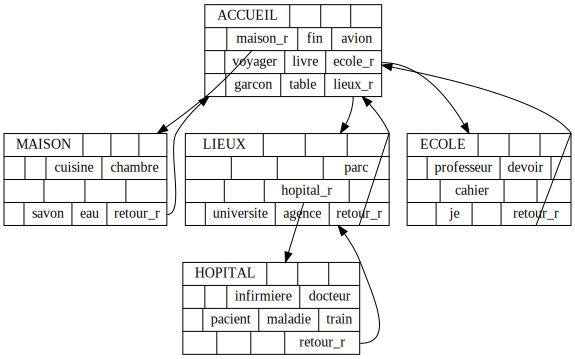

In [64]:
g1=Grid('testing/grid_3_6p_raw.csv', 4,4)
g1.display()

VOC_AVANT: 
{'maison_r@accueil': ['maison_r', 1, 1, 'accueil', 'maison'], 'voyager@accueil': ['voyager', 2, 1, 'accueil', None], 'garcon@accueil': ['garcon', 3, 1, 'accueil', None], 'fin@accueil': ['fin', 1, 2, 'accueil', None], 'livre@accueil': ['livre', 2, 2, 'accueil', None], 'table@accueil': ['table', 3, 2, 'accueil', None], 'avion@accueil': ['avion', 1, 3, 'accueil', None], 'ecole_r@accueil': ['ecole_r', 2, 3, 'accueil', 'ecole'], 'lieux_r@accueil': ['lieux_r', 3, 3, 'accueil', 'lieux'], 'chambre@maison': ['chambre', 1, 3, 'maison', None], 'cuisine@maison': ['cuisine', 1, 2, 'maison', None], 'savon@maison': ['savon', 3, 1, 'maison', None], 'eau@maison': ['eau', 3, 2, 'maison', None], 'retour_r@maison': ['retour_r', 3, 3, 'maison', 'accueil'], 'parc@lieux': ['parc', 1, 3, 'lieux', None], 'hopital_r@lieux': ['hopital_r', 2, 2, 'lieux', 'hopital'], 'universite@lieux': ['universite', 3, 1, 'lieux', None], 'agence@lieux': ['agence', 3, 2, 'lieux', None], 'retour_r@lieux': ['retour_r', 

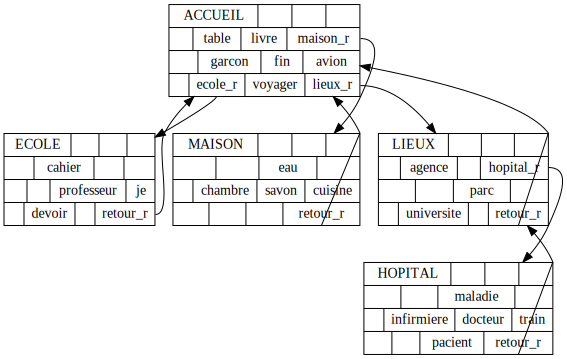

In [65]:
g2=g1.shuffle()
g2.display()

In [ ]:
# Valider que la première page de la grille soit l'accueil
pages_dict = self.get_page_dict()
first_page_name = pages_dict.
first_page = 
if first_page_name != 'accueil':
  for page_name, page in pages_dict.items():
    if page_name == 'accueil':



In [8]:
d={'a':1, 'b':2, 'c':3}
t=list(d.items())
t[0], t[2] = t[2], t[0]
d=dict(t)
d

# for i in d:
  # if i == 'b':
    # print(i.index(d))


{'c': 3, 'b': 2, 'a': 1}